# PROJETO SEMANTIX

### IMPORTAÇÃO DOS PACOTES

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, StratifiedKFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

### CARREGAR E TRATAR OS DADOS

In [87]:
# Carregar os três datasets
df_2021 = pd.read_csv("si-veic-2021.csv", sep=';', encoding='latin1')
df_2022 = pd.read_csv("si-veic-2022.csv", sep=';', encoding='latin1')
df_2023 = pd.read_csv("si-veic-2023.csv", sep=';', encoding='latin1')

# Adicionar uma coluna para indicar o ano
df_2021["ANO"] = 2021
df_2022["ANO"] = 2022
df_2023["ANO"] = 2023

# Unir tudo
df = pd.concat([df_2021, df_2022, df_2023], ignore_index=True)

# Visualizar colunas para checar se tudo está alinhado
print(df_completo.columns)


Index([' Nº_boletim', 'data_hora_boletim', '  seq_veic', ' cod_categ',
       ' descricao_categoria', ' cod_especie', '  descricao_especie',
       ' cod_situacao', ' desc_situacao', ' tipo_socorro',
       ' desc_tipo_socorro', 'ANO', ' N§_boletim'],
      dtype='object')


In [88]:
# Remover espaços nos nomes das colunas
df.columns = df.columns.str.strip()

# Verificar os primeiros dados
print(df.head())

           Nº_boletim data_hora_boletim  seq_veic  cod_categ  \
0  2021-014038208-001  21/03/2021 12:29         1          3   
1  2021-014038208-001  21/03/2021 12:29         2          3   
2  2021-014050858-001  21/03/2021 14:03         1          3   
3  2021-014050858-001  21/03/2021 14:03         2          3   
4  2021-014056225-001  21/03/2021 15:18         2          3   

              descricao_categoria  cod_especie  \
0  PARTICULAR                                6   
1  PARTICULAR                                4   
2  PARTICULAR                               14   
3  PARTICULAR                                6   
4  PARTICULAR                                6   

                descricao_especie  cod_situacao    desc_situacao  \
0  AUTOMOVEL                                  1  EM MOVIMENTO      
1  MOTOCICLETA                                1  EM MOVIMENTO      
2  CARROCA                                    1  EM MOVIMENTO      
3  AUTOMOVEL                              

C:\Users\winga\AppData\Local\Temp\ipykernel_13516\2496896109.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)



Coluna: Nº_boletim
Nº_boletim
2021-056709684-004    15
2021-052009050-001    12
2022-011851247-001    10
2021-008470526-001    10
2022-000038934-001     9
                      ..
2022-047825510-001     1
2021-040968564-001     1
2021-040990116-001     1
2022-047823549-001     1
2021-000383010-001     1
Name: count, Length: 23269, dtype: int64

Coluna: data_hora_boletim
data_hora_boletim
25/11/2021 17:22    15
28/10/2021 07:54    12
19/03/2022 14:26    10
18/02/2021 04:33    10
30/07/2022 02:07     9
                    ..
24/08/2022 12:30     1
30/07/2022 10:20     1
24/08/2022 15:59     1
24/08/2022 18:14     1
28/10/2023 12:50     1
Name: count, Length: 36299, dtype: int64

Coluna: seq_veic
seq_veic
1     37099
2     28228
3      2447
4       412
5       111
6        44
7        17
8        10
9         6
10        4
12        2
11        2
14        1
15        1
13        1
Name: count, dtype: int64

Coluna: descricao_categoria
descricao_categoria
PARTICULAR            59734
ALUG

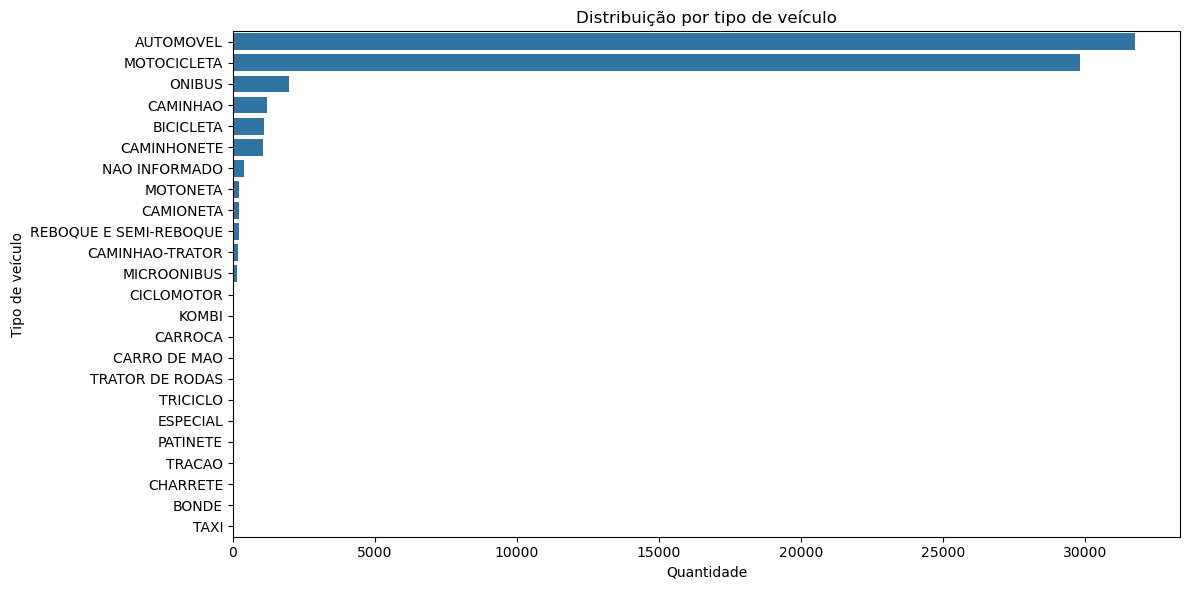

In [89]:

# Selecionar colunas úteis
df = df[['Nº_boletim', 'data_hora_boletim', 'seq_veic', 
         'descricao_categoria', 'descricao_especie', 
         'desc_situacao', 'desc_tipo_socorro']]

# Remover espaços em branco nas strings
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Verificar valores únicos de cada coluna
for col in df.columns:
    print(f"\nColuna: {col}")
    print(df[col].value_counts())

### VISUALIZAR INFORMAÇÕES

In [ ]:
# Gráfico de barras para a espécie do veículo
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='descricao_especie', order=df['descricao_especie'].value_counts().index)
plt.title('Distribuição por tipo de veículo')
plt.xlabel('Quantidade')
plt.ylabel('Tipo de veículo')
plt.tight_layout()
plt.show()

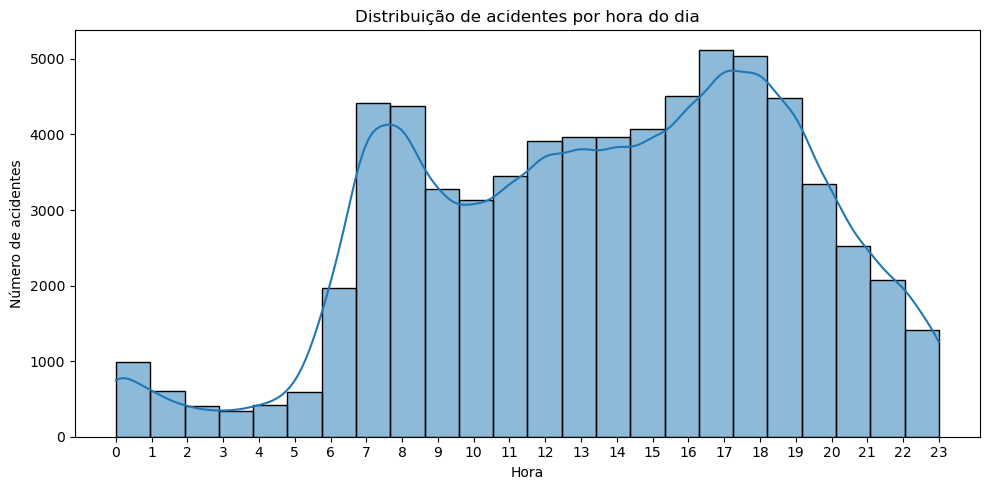

In [90]:
# Converter coluna para datetime
df['data_hora_boletim'] = pd.to_datetime(df['data_hora_boletim'], format='%d/%m/%Y %H:%M', errors='coerce')

# Extrair a hora
df['hora'] = df['data_hora_boletim'].dt.hour

# Plotar distribuição dos acidentes por hora
plt.figure(figsize=(10,5))
sns.histplot(df['hora'].dropna(), bins=24, kde=True)
plt.title('Distribuição de acidentes por hora do dia')
plt.xlabel('Hora')
plt.ylabel('Número de acidentes')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


### MACHINE LEARNING

In [91]:
# Definir quais tipos de socorro consideraremos como "precisou de socorro"
tipos_com_socorro = ['AMBULANCIA', 'TERCEIROS', 'VIATURA PMMG', 'VEICULO ENVOLVIDO']

# Criar a coluna binária
df['precisou_socorro'] = df['desc_tipo_socorro'].apply(lambda x: 1 if x in tipos_com_socorro else 0)

# Verificar proporção
print(df['precisou_socorro'].value_counts(normalize=True))



precisou_socorro
0    0.746553
1    0.253447
Name: proportion, dtype: float64


In [92]:
# Selecionar colunas relevantes
dados_modelo = df[['descricao_categoria', 'descricao_especie', 'desc_situacao', 'hora', 'precisou_socorro']]

# Remover linhas com valores ausentes
dados_modelo.dropna(inplace=True)

# Verificar rapidamente
print(dados_modelo.head())

  descricao_categoria descricao_especie desc_situacao  hora  precisou_socorro
0          PARTICULAR         AUTOMOVEL  EM MOVIMENTO    12                 0
1          PARTICULAR       MOTOCICLETA  EM MOVIMENTO    12                 0
2          PARTICULAR           CARROCA  EM MOVIMENTO    14                 0
3          PARTICULAR         AUTOMOVEL  EM MOVIMENTO    14                 0
4          PARTICULAR         AUTOMOVEL  EM MOVIMENTO    15                 0


C:\Users\winga\AppData\Local\Temp\ipykernel_13516\328041757.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_modelo.dropna(inplace=True)


In [93]:
# Separar X (features) e y (target)
X = dados_modelo.drop('precisou_socorro', axis=1)
y = dados_modelo['precisou_socorro']

# Codificar variáveis categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

print(X_encoded.head())


   hora  descricao_categoria_APRENDIZAGEM  \
0    12                             False   
1    12                             False   
2    14                             False   
3    14                             False   
4    15                             False   

   descricao_categoria_MISSAO DIPLOMATICA  descricao_categoria_NAO INFORMADO  \
0                                   False                              False   
1                                   False                              False   
2                                   False                              False   
3                                   False                              False   
4                                   False                              False   

   descricao_categoria_OFICIAL  descricao_categoria_PARTICULAR  \
0                        False                            True   
1                        False                            True   
2                        False                    

              precision    recall  f1-score   support

           0       0.80      0.91      0.85     10211
           1       0.55      0.31      0.40      3466

    accuracy                           0.76     13677
   macro avg       0.67      0.61      0.62     13677
weighted avg       0.73      0.76      0.74     13677



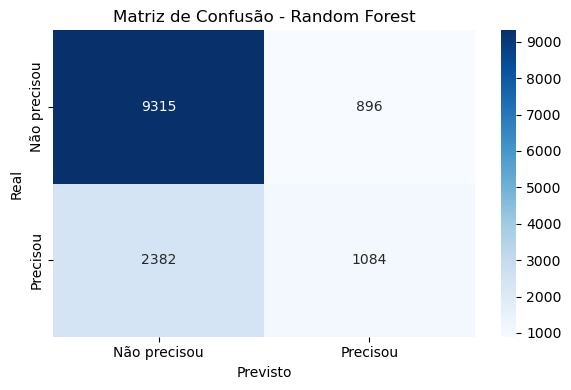

In [94]:
# Dividir em dados de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Criar e treinar o modelo
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = modelo_rf.predict(X_test)

# Mostrar relatório de desempenho
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Não precisou', 'Precisou'], yticklabels=['Não precisou', 'Precisou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.tight_layout()
plt.show()


**Nota-se que o modelo está ótimo para avaliar quem não precisou, mas está com uma acurácia baixa para quem precisou, que para nós seria a vertente mais importante.**   
Sendo assim trataremos com hiperparâmetros para melhorar esse modelo.

### HIPERPARÂMETROS PARA MELHORIA DA PREVISÃO

In [95]:
# Parâmetros para testar
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train, y_train)

print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Melhores parâmetros encontrados:
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.94      0.68      0.79     10211
           1       0.48      0.86      0.62      3466

    accuracy                           0.73     13677
   macro avg       0.71      0.77      0.70     13677
weighted avg       0.82      0.73      0.74     13677



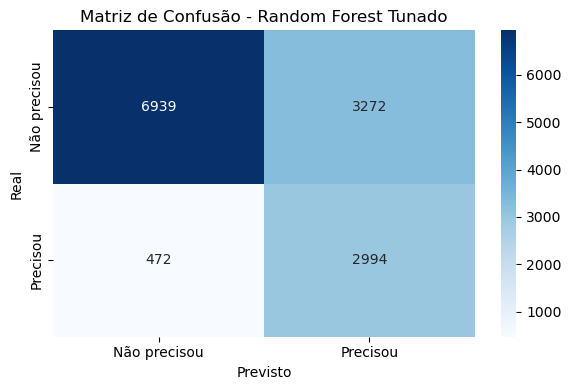

In [96]:
# Melhor modelo treinado
best_model = grid_search.best_estimator_

# Previsões
y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues', xticklabels=['Não precisou', 'Precisou'], yticklabels=['Não precisou', 'Precisou'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest Tunado')
plt.tight_layout()
plt.show()

**Percebe-se uma perda de acurácia na previsão de quem não precisou, porém, temos uma grande melhoria na vertente de quem precisou, sendo uma melhoria ótima para a importância do modelo de previsão.**

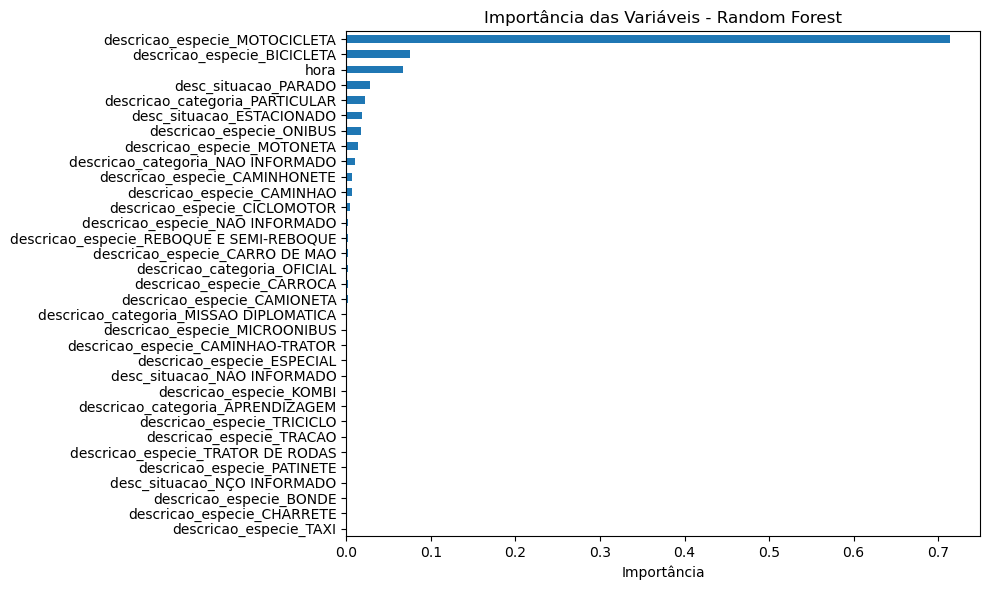

In [83]:
importances = best_model.feature_importances_
features = X_encoded.columns

import pandas as pd
feature_importance = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(10,6))
feature_importance.plot(kind='barh')
plt.title('Importância das Variáveis - Random Forest')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()